We're just looking for interesting observations regarding our data set :)

Let's start with imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

Let's continue loading the dataset

In [2]:
df = pd.read_csv("feature_data.csv", index_col=0)
labels = pd.read_csv("label_data.csv", index_col=0)

Now, let's see which features are we working with

In [3]:
print(f"Our dataset size is: {df.shape}")
df.head(1)

Our dataset size is: (89542, 33)


,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,order_type,...,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13
51014,309.0,2016,May,week_20,13,2,0.0,0,PRT,Offline TA/TO,...,0,0.0,215.0,0.0,0,0.0,0.250606,17.588299,True,1.0


Let's try and see which categorical features we're working with:
<br>
Here's a list of each categorical feature (seen by pandas as type 'O'), and the number of unique features it has

In [4]:
categorical_cols = [col_name for col_name in df.columns if df[col_name].dtype == 'O']
[(col_name, df[col_name].nunique(dropna=True)) for col_name in categorical_cols]

[('order_month', 12),
 ('order_week', 53),
 ('country', 163),
 ('order_type', 8),
 ('acquisition_channel', 5),
 ('deposit_type', 3),
 ('customer_type', 4)]

We can immediately see that our most problematic categorical variable is 'country', as it has 163 unique values.
Let's see how the different countries are distributed across the dataset:

<AxesSubplot:ylabel='Countries'>

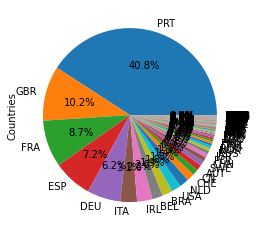

In [5]:
df["country"].value_counts().plot(kind='pie', label='Countries', autopct='%1.1f%%')

Seems as though about a third of the orders in our dataset are set for Portugal.
<br>
We can get the top 5 countries and use them as dummy variables with another 'other' variable instead of using 163 dummy variables.

In [6]:
def plot_top_n_countries(df, n):
    top_n_countries = list(df["country"].value_counts().head(n).index)
    series = pd.Series([country if country in top_n_countries else 'OTHER' for country in df["country"]])
    series.value_counts().plot(kind='pie', title=f'Top {n} Countries', autopct='%1.1f%%', label='')
    text = f"{series[series == 'OTHER'].value_counts().sum() * 100 / len(series)}% of countries labeled 'OTHER'"
    plt.figtext(0.5, 0.01, text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.show()

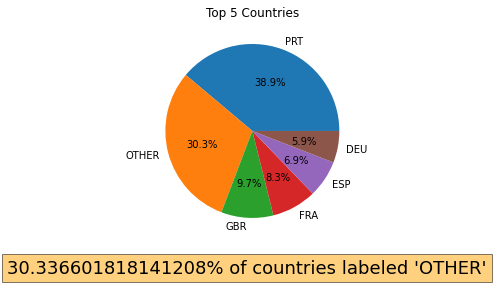

In [7]:
plot_top_n_countries(df, 5)


If 30% of 'other' countries is too much, we can take the top 10 or 15 countries, and then their distribution will be:

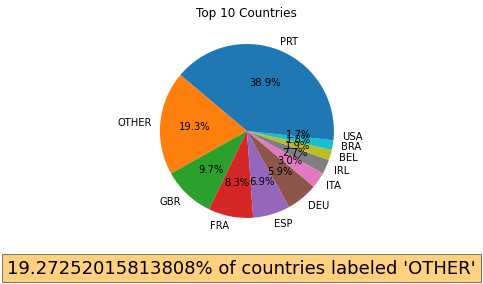

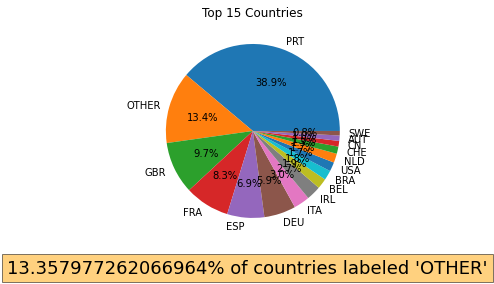

In [8]:
plot_top_n_countries(df, 10)
plot_top_n_countries(df, 15)

In [9]:
# This function creates dummy features for a given list of columns
def dummify(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col, dummy_na=False)
        df = df.drop(col, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

Now, let's see how the rest of the categorical features are distributed

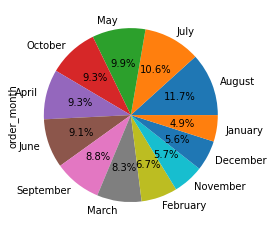

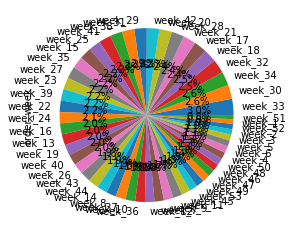

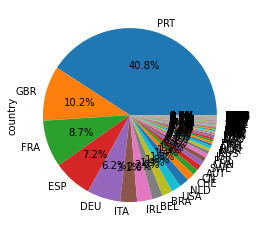

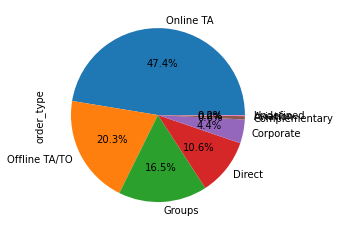

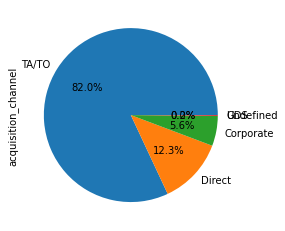

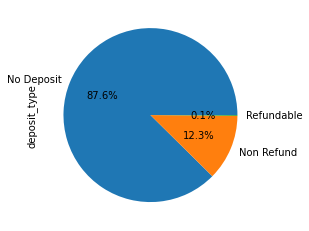

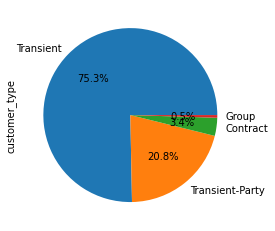

In [10]:
for category in categorical_cols:
    plt.plot()
    df[category].value_counts().plot(kind='pie', label=category, autopct='%1.1f%%')
    plt.show()

Let's see if there's any connection between the month / week features and actual cancellations

In [11]:
merged_df = df.merge(labels, right_index=True, left_index=True)

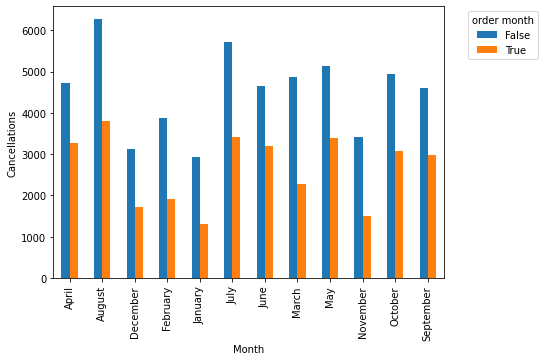

In [12]:
dfu = merged_df.groupby(['order_month']).cancelation.value_counts().unstack()
dfu.plot.bar(figsize=(7, 5))
plt.legend(title='order month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Month')
plt.ylabel('Cancellations')
plt.show()

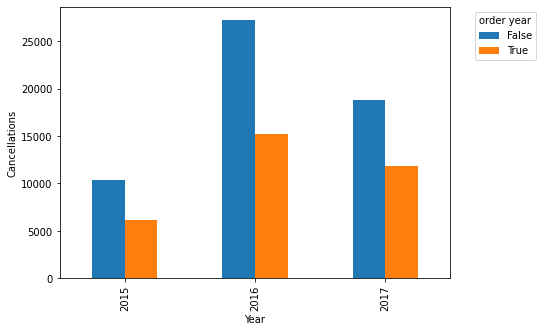

In [13]:
dfu = merged_df.groupby(['order_year']).cancelation.value_counts().unstack()
dfu.plot.bar(figsize=(7, 5))
plt.legend(title='order year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Year')
plt.ylabel('Cancellations')
plt.show()


In [14]:
# Uncomment this code to see the distribution of each feature
# for col in df.columns:
#     if col in categorical_cols or col == "country":
#         continue
#     plt.plot()
#     plt.title(col)
#     df[col].plot.kde()
#     plt.show()

<AxesSubplot:ylabel='changes'>

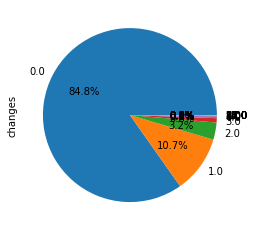

In [39]:
# Here we can see that 'changes' can also be turned into a boolean feature - has_changed
df["changes"].value_counts().plot(kind='pie', label="changes", autopct='%1.1f%%')

In [16]:
test_df = pd.DataFrame()
test_df["people"] = df["adults"] + df["babies"] + df["children"]


In [17]:
test_df["people"].value_counts()

2.0     61621
1.0     16822
3.0      7920
4.0      2932
0.0       130
5.0       103
26.0        3
12.0        2
50.0        1
20.0        1
55.0        1
6.0         1
10.0        1
Name: people, dtype: int64

In [18]:
df.columns

Index(['time_until_order', 'order_year', 'order_month', 'order_week',
       'order_day_of_month', 'adults', 'children', 'babies', 'country',
       'order_type', 'acquisition_channel', 'prev_canceled',
       'prev_not_canceled', 'changes', 'deposit_type', 'agent', 'company',
       'customer_type', 'adr', 'anon_feat_0', 'anon_feat_1', 'anon_feat_2',
       'anon_feat_3', 'anon_feat_4', 'anon_feat_5', 'anon_feat_6',
       'anon_feat_7', 'anon_feat_8', 'anon_feat_9', 'anon_feat_10',
       'anon_feat_11', 'anon_feat_12', 'anon_feat_13'],
      dtype='object')

<AxesSubplot:ylabel='company'>

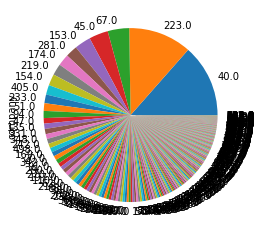

In [19]:
# Maybe this could be of use?
df["company"].value_counts().plot(kind='pie', label="company")

Let's try to see all the different countries so we can start mapping them by different parameters (continent, GDP score etc.)

In [20]:
# It seems that CN and CHN both represent China in their ISO codes, so we can unite them
merged_df.loc[merged_df["country"] == "CN", "country"] = "CHN"

In [21]:
merged_df["country"].unique()

array(['PRT', 'ESP', 'DEU', 'GBR', 'BRA', 'AGO', nan, 'ISR', 'FRA', 'TUR',
       'ITA', 'CHN', 'HUN', 'IRL', 'EST', 'USA', 'POL', 'NOR', 'AUT',
       'NLD', 'CIV', 'DNK', 'AUS', 'RUS', 'BEL', 'CZE', 'CMR', 'CHE',
       'MOZ', 'IDN', 'FIN', 'ROU', 'TJK', 'SWE', 'LUX', 'HRV', 'QAT',
       'TUN', 'GRC', 'LBN', 'KOR', 'LKA', 'MAR', 'TWN', 'ZAF', 'IND',
       'DZA', 'BGR', 'JPN', 'ARE', 'IRN', 'CYP', 'STP', 'MEX', 'SVK',
       'BLR', 'SRB', 'EGY', 'GHA', 'NZL', 'PRI', 'ECU', 'THA', 'ARG',
       'PHL', 'JOR', 'LTU', 'COL', 'URY', 'ISL', 'MAC', 'MKD', 'UKR',
       'SVN', 'ALB', 'SAU', 'KWT', 'SEN', 'SGP', 'AND', 'KAZ', 'GEO',
       'OMN', 'MDV', 'AZE', 'PER', 'DOM', 'NGA', 'ASM', 'CHL', 'CAF',
       'MYS', 'CRI', 'PAK', 'VEN', 'BHR', 'KEN', 'CPV', 'JEY', 'LVA',
       'GLP', 'MUS', 'MCO', 'MNE', 'HKG', 'BGD', 'CUB', 'GIB', 'BRB',
       'IRQ', 'GNB', 'PAN', 'SUR', 'LAO', 'FRO', 'BFA', 'MLT', 'PLW',
       'IMN', 'VNM', 'BOL', 'LCA', 'ARM', 'GAB', 'TGO', 'TZA', 'PRY',
       'GTM', '

In [22]:
continents = {
    "west-europe": ["PRT", "ESP", "DEU", "GBR", "FRA", "ITA", "IRL", "NOR", "AUT", "NLD", "DNK", "BEL",
                    "CHE", "FIN", "SWE", "LUX", "GRC", "CYP", "ISL", "SVN", "AND", "JEY", "MCO", "GIB",
                    "SMR", "LIE", "GGY"],
    "east-europe": ["HUN", "EST", "POL", "CZE", "ROU", "HRV", "BGR", "SVK", "BLR", "SRB", "LTU", "MKD",
                    "UKR", "ALB", "GEO", "AZE", "LVA", "MNE", "MLT", "ARM", "BIH"],
    "south-america": ["BRA", "MEX", "PRI", "ECU", "ARG", "COL", "URY", "PER", "DOM", "CHL", "CRI", "VEN",
                      "GLP", "CUB", "BRB", "PAN", "SUR", "BOL", "LCA", "PRY", "GTM", "ABW", "NIC", "JAM",
                      "GUY", "HND", "VGB", "KNA"],
    "africa": ["AGO", "CIV", "CMR", "MOZ", "TUN", "MAR", "ZAF", "DZA", "STP", "EGY", "GHA", "SEN", "NGA",
               "CAF", "KEN", "CPV", "MUS", "GNB", "BFA", "GAB", "TGO", "TZA", "ZMB", "LBY", "MRT", "SYC",
               "UGA", "MDG", "MWI", "BEN", "BDI", "NAM", "ZWE", "SLE", "BWA", "SDN"],
    "middle-east": ["ISR", "TUR", "QAT", "LBN", "ARE", "IRN", "JOR", "SAU", "KWT", "OMN", "BHR", "IRQ",
                    "SYR"],
    "asia": ["CHN", "RUS", "TJK", "MAC", "KAZ", "HKG"],
    "east-asia": ["KOR", "JPN", "KHM"],
    "south-asia": ["IDN", "LKA", "TWN", "IND", "THA", "PHL", "SGP", "MDV", "MYS", "PAK", "BGD", "LAO", "VNM"],
    "north-america": ["USA"],
    "australia": ["AUS", "NZL", "FJI"],
    "other": ["ASM", "FRO", "PLW", "IMN", "ATF", "MYT", "PYF", "COM", "ATA", "UMI", "TMP", np.nan]
}

country_to_continent = {}
for continent in continents.keys():
    country_to_continent.update({country: continent for country in continents[continent]})

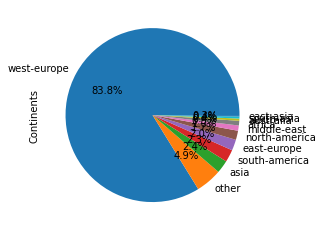

In [23]:
merged_df["continent"] = [country_to_continent[country] for country in merged_df["country"]]
merged_df["continent"].value_counts().plot(kind='pie', label='Continents', autopct='%1.1f%%')
plt.show()

In [24]:
seasons_north = {
    "January": "Winter",
    "February": "Winter",
    "March": "Spring",
    "April": "Spring",
    "May": "Spring",
    "June": "Summer",
    "July": "Summer",
    "August": "Summer",
    "September": "Fall",
    "October": "Fall",
    "November": "Fall",
    "December": "Winter"
}

seasons_south = {
    "January": "Summer",
    "February": "Summer",
    "March": "Fall",
    "April": "Fall",
    "May": "Fall",
    "June": "Winter",
    "July": "Winter",
    "August": "Winter",
    "September": "Spring",
    "October": "Spring",
    "November": "Spring",
    "December": "Summer"
}

southern_hemisphere = ["south-america", "africa", "south-asia", "australia"]

def label_season(row):
    if row["continent"] in southern_hemisphere:
        return seasons_south.get(row["order_month"], np.nan)
    return seasons_north.get(row["order_month"], np.nan)

merged_df["season"] = merged_df.apply(label_season, axis=1)

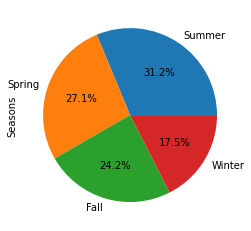

In [25]:
merged_df["season"].value_counts().plot(kind='pie', label='Seasons', autopct='%1.1f%%')
plt.show()

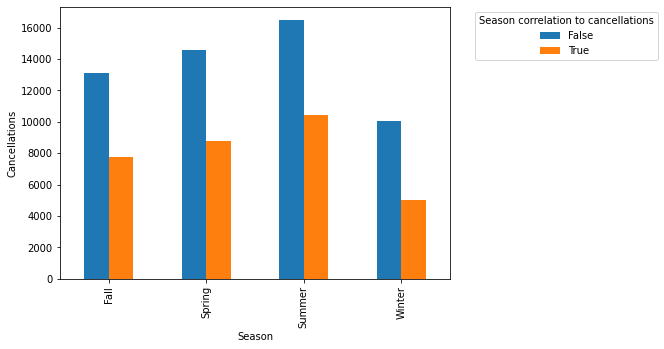

In [26]:
dfu = merged_df.groupby(['season']).cancelation.value_counts().unstack()
dfu.plot.bar(figsize=(7, 5))
plt.legend(title='Season correlation to cancellations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Season')
plt.ylabel('Cancellations')
plt.show()

In [27]:
df.columns

Index(['time_until_order', 'order_year', 'order_month', 'order_week',
       'order_day_of_month', 'adults', 'children', 'babies', 'country',
       'order_type', 'acquisition_channel', 'prev_canceled',
       'prev_not_canceled', 'changes', 'deposit_type', 'agent', 'company',
       'customer_type', 'adr', 'anon_feat_0', 'anon_feat_1', 'anon_feat_2',
       'anon_feat_3', 'anon_feat_4', 'anon_feat_5', 'anon_feat_6',
       'anon_feat_7', 'anon_feat_8', 'anon_feat_9', 'anon_feat_10',
       'anon_feat_11', 'anon_feat_12', 'anon_feat_13'],
      dtype='object')

<AxesSubplot:>

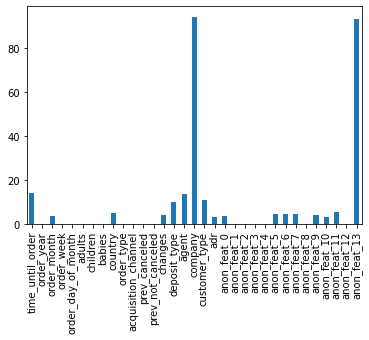

In [28]:
(df.isnull().sum() * 100 / len(df)).plot.bar()

5776

Looks like we can get rid of "company" and "anon_feat_13"

In [29]:
processed_df = df.drop(columns=["company", "anon_feat_13"])

In [30]:
# Let's convert categorical columns to numerical ones
months = [np.nan, "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
processed_df["order_month"] = [months.index(month) for month in processed_df["order_month"]]

In [31]:
processed_df["order_week"] = [int(week.replace("week_", "")) for week in processed_df["order_week"]]

In [32]:
processed_df["deposit_exists"] = [deposit_type != "No Deposit" for deposit_type in processed_df["deposit_type"]]
processed_df = processed_df.drop(columns=["deposit_type"])

In [33]:
# Let's say we'll keep the top 10 countries
top_n_countries = list(df["country"].value_counts().head(10).index)
processed_df["country"] = [country if country in top_n_countries else "OTHER" for country in processed_df["country"]]

In [34]:
# Let's mark Undefined values as NaN
processed_df.loc[processed_df["acquisition_channel"] == "Undefined", "acquisition_channel"] = np.nan
processed_df.loc[processed_df["order_type"] == "Undefined", "order_type"] = np.nan

In [35]:
processed_df = dummify(processed_df, ["country", "order_type", "acquisition_channel", "customer_type"])

Now we don't have any categorical features in our dataset.
Next step is to deal with missing values.

In [36]:
# Let's replace all missing values with their column's mean values
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imp_mean.fit(processed_df)

processed_df = pd.DataFrame(data=imp_mean.transform(processed_df), columns=processed_df.columns)

In [37]:
# Let's detect outliers in our dataset
from sklearn.covariance import EllipticEnvelope
prediction = EllipticEnvelope(random_state=0).fit_predict(processed_df)
print(f"EllipticEnvelope detected {sum(prediction == -1)} outliers")

EllipticEnvelope detected 8955 outliers


In [38]:
from sklearn.ensemble import IsolationForest
prediction = IsolationForest().fit_predict(processed_df)
print(f"IsolationForest detected {sum(prediction == -1)} outliers")

IsolationForest detected 5934 outliers
